In [70]:
import csv
import os
#to install fitparse, run 
#sudo pip3 install -e git+https://github.com/dtcooper/python-fitparse#egg=python-fitparse
import fitparse
import pytz
from datetime import datetime
import datetime as DT
allowed_fields = ['timestamp','heart_rate','timestamp_16']
required_fields = ['heart_rate']

UTC = pytz.UTC
import glob
print()

def main():
    files = glob.glob("data/**/*")  #os.listdir(os.getcwd()+'/data')
    fit_files = [file for file in files if file[-4:].lower()=='.fit']
    for file in fit_files:
        new_filename = os.getcwd()+'/'+file[:-4] + '.csv'
        if os.path.exists(new_filename):
            print('%s already exists. skipping.' % new_filename)
            continue
        fitfile = fitparse.FitFile(os.getcwd()+'/'+file,  
            data_processor=fitparse.StandardUnitsDataProcessor())
        
        print('converting %s' % file)
        write_fitfile_to_csv(fitfile, new_filename)
    print('finished conversions')

epoch = datetime.utcfromtimestamp(0)
def unix_time_s(dt):
    return (dt - epoch).total_seconds()

def write_fitfile_to_csv(fitfile, output_file='test_output.csv'):
    messages = fitfile.messages
    data = []
    timestamp_16_found = False
    initial_timestamp = None
    initial_timestamp_16 = None
    last_timestamp = None
    counter = 0
    for i,m in enumerate(messages):
        
        skip=False
        if not hasattr(m, 'fields'):
            continue
        fields = m.fields
        #check for important data types
        mdata = {}
#         print(i, fields)
#         print('--')
        for field in fields:
            
            if field.name in allowed_fields:
                if field.name=='timestamp' and timestamp_16_found is False :
                    initial_timestamp = unix_time_s(field.value)
                    #mdata['timestamp'] = field.value # fill in the value with the timestamp. 
                if field.name=='timestamp_16':
                    if timestamp_16_found is False:
                        timestamp_16_found = True
                        initial_timestamp_16 = field.value
                    else:
                        # this is in seconds since epoch
                        mdata['timestamp_s'] = initial_timestamp + (field.value - initial_timestamp_16)
                        mdata['timestamp'] = datetime.utcfromtimestamp(mdata['timestamp_s']).strftime('%Y-%m-%d %H:%M:%S')
                        
                mdata[field.name] = field.value
            
        
        for rf in required_fields:
            if rf not in mdata:
                skip=True
                
        print(mdata)
        print('--')
        
        try:
            #print(last_timestamp, mdata['timestamp_s'])
            if last_timestamp is None:
                last_timestamp = mdata['timestamp_s']
            #print(i,last_timestamp > mdata['timestamp_s'])
            if last_timestamp > mdata['timestamp_s']:
                skip = True
        except:
            pass
        
        if not skip:
            counter += 1
            
            data.append(mdata)

    
    #write to csv
    with open(output_file, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(allowed_fields)
        for entry in data:
            writer.writerow([ str(entry.get(k, '')) for k in allowed_fields])
    print('wrote %s' % output_file)

main()


/home/sholto/Desktop/heartRateChallenge/data/oli/5021192819.csv already exists. skipping.
/home/sholto/Desktop/heartRateChallenge/data/oli/5031939967.csv already exists. skipping.
/home/sholto/Desktop/heartRateChallenge/data/alec/5031941619.csv already exists. skipping.
/home/sholto/Desktop/heartRateChallenge/data/chris/57384097266.csv already exists. skipping.
/home/sholto/Desktop/heartRateChallenge/data/chris/57384181177.csv already exists. skipping.
/home/sholto/Desktop/heartRateChallenge/data/chris/57384198528.csv already exists. skipping.
/home/sholto/Desktop/heartRateChallenge/data/chris/57384087184.csv already exists. skipping.
converting data/chris/57570058101.fit
{}
--
{'timestamp': datetime.datetime(2020, 6, 3, 14, 0)}
--
{}
--
{'timestamp': datetime.datetime(2020, 6, 3, 14, 0)}
--
{'timestamp': datetime.datetime(2020, 6, 3, 14, 0)}
--
{'timestamp': datetime.datetime(2020, 6, 3, 14, 0)}
--
{'timestamp': datetime.datetime(2020, 6, 3, 14, 0)}
--
{'timestamp': datetime.datetime

{}
--
{'timestamp': datetime.datetime(2020, 6, 4, 8, 40)}
--
{}
--
{'timestamp': datetime.datetime(2020, 6, 4, 8, 40)}
--
{'timestamp': datetime.datetime(2020, 6, 4, 8, 40)}
--
{'timestamp': datetime.datetime(2020, 6, 4, 8, 40)}
--
{'timestamp': datetime.datetime(2020, 6, 4, 8, 40)}
--
{'timestamp': datetime.datetime(2020, 6, 4, 8, 40)}
--
{'timestamp': datetime.datetime(2020, 6, 4, 8, 40)}
--
{}
--
{'timestamp_16': 26524, 'heart_rate': 88}
--
{'timestamp_s': 1591260060.0, 'timestamp': '2020-06-04 08:41:00', 'timestamp_16': 26584, 'heart_rate': 81}
--
{'timestamp_s': 1591260120.0, 'timestamp': '2020-06-04 08:42:00', 'timestamp_16': 26644, 'heart_rate': 87}
--
{'timestamp_s': 1591260180.0, 'timestamp': '2020-06-04 08:43:00', 'timestamp_16': 26704, 'heart_rate': 81}
--
{'timestamp': datetime.datetime(2020, 6, 4, 8, 44)}
--
{'timestamp_s': 1591260240.0, 'timestamp': '2020-06-04 08:44:00', 'timestamp_16': 26764, 'heart_rate': 86}
--
{'timestamp': datetime.datetime(2020, 6, 4, 8, 45)}
--
{'

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md



def ingest(filename):
    df = pd.read_csv(filename).fillna(value = 0)
    df = df.dropna()
    try:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    except:
        
        df['timestamp'] = pd.to_datetime(df['Time'])
        df['heart_rate'] = df['Heart Rate']
    df=df.sort_values('timestamp')
    return df


def partition_df(df):
    past_r = None
    start_index = 0
    list_of_partitioned_dfs = []
    for r in df.iterrows():
        if past_r is not None:
            t_delta = (r[1]['timestamp'] - past_r[1]['timestamp']).total_seconds() /60
            
            if t_delta > 10: # if theres more than a 10min break
                list_of_partitioned_dfs.append(df[start_index: r[0]-1])
                start_index = r[0]
        past_r = r
        
    list_of_partitioned_dfs.append(df[start_index: len(df)])
    
    return list_of_partitioned_dfs


def plot(df, filename):
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    plt.xticks( rotation=25 )
    
    plt.plot(df['timestamp'],df['heart_rate'])
    plt.gcf().subplots_adjust(bottom=0.5)
    plt.savefig(filename.replace('.csv',''))
    plt.show()


def calc_points(df, filename, friend):
    past_r = None
    total_points = 0
    for r in df.iterrows():
        if past_r is not None:
            t_delta = (r[1]['timestamp'] - past_r[1]['timestamp']).total_seconds() /60
            hr = r[1]['heart_rate']
            if hr < 120:
                hr = 0
            points = max((hr-friend.resting_hr),0)
            points = points * t_delta
            total_points += points
        past_r = r
    return total_points

files = os.listdir(os.getcwd()+'/data')
csv_files = [file for file in files if file[-4:].lower()=='.csv']

class friend:
    def __init__(self, name, resting_hr):
        self.name = name
        self.resting_hr = resting_hr
        self.points = 1
        
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)
        
        


data/oli/5021192819.csv
485


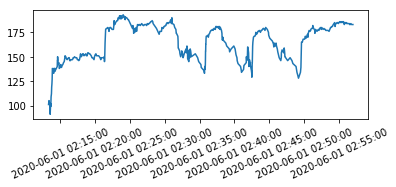

data/oli/5031939967.csv
269


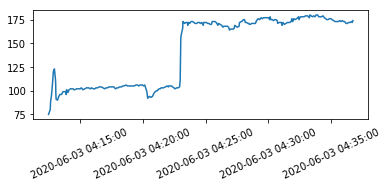

data/alec/5031941619.csv
643


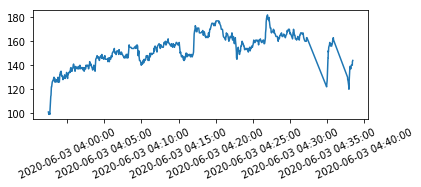

data/chris/57384080081.csv
25
data/chris/57570058101.csv
31
2
data/chris/57384097266.csv
41
363


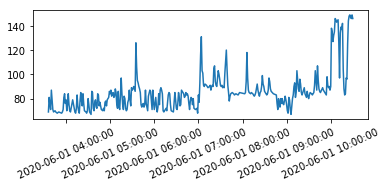

data/chris/57384198528.csv
0
data/chris/57632996270.csv
5
3
13
2
2
6
11
5
2
12
0
2
9
0
39
130
data/chris/57384087184.csv
6
11
11
30
5
2
0
2
25
2
4
12
0
34
91
data/chris/57645562290.csv
210


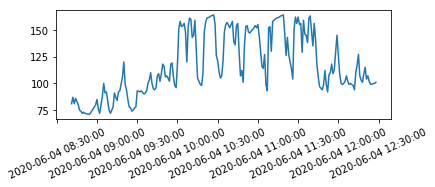

data/chris/57384181177.csv
107


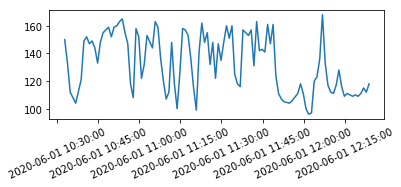

data/chris/57541092961.csv
0
data/chris/57385289495.csv
8
data/chris/57522694770.csv
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
data/chris/57541068887.csv
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
50


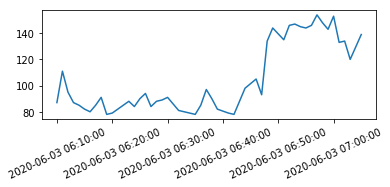

data/chris/57541116911.csv
0
data/galen/5032011836.csv
589


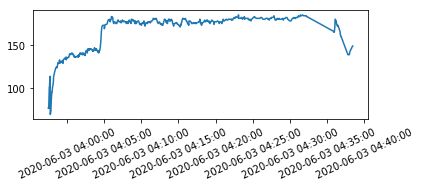

data/mia/5021694216.csv
606


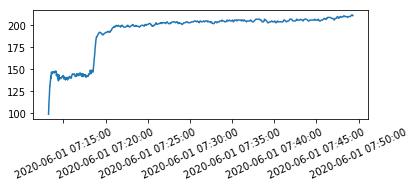

data/mia/5032386220.csv
869


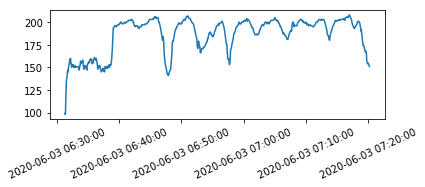

data/mia/5027230008.csv
1565


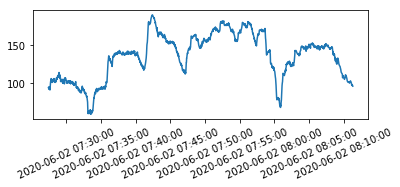

data/kacy/5026939865.csv
520


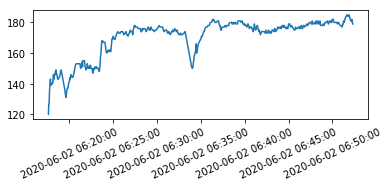

data/kacy/5037456040.csv
1187


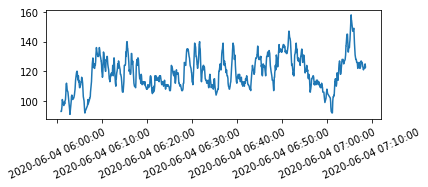

data/sholto/2020-06-01.csv
33


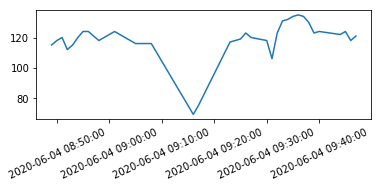

6
1
36
7
2
249


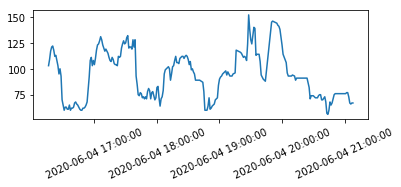

6
data/sholto/2020-06-03.csv
29


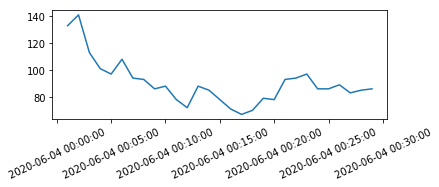

61


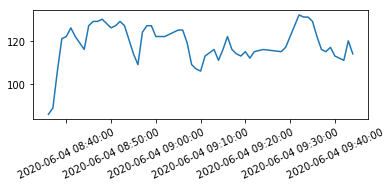

2
1
49


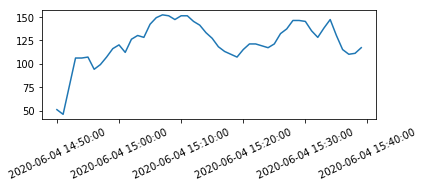

In [72]:
friends = [friend('alec', 58), friend('kacy', 47), friend('chris', 62.5), friend('oli', 48), friend('mia', 56), friend('sholto', 56), friend('galen', 57)]

files = glob.glob("data/**/*") # = os.listdir(os.getcwd()+'/data')

csv_files = [file for file in files if file[-4:].lower()=='.csv']


for c in csv_files:
    filename = c
    try:
        print(filename)
        df = ingest(filename)[1:]
        
        l_of_dfs = partition_df(df)
        
        for i, df in enumerate(l_of_dfs):
            print(len(df))
            if len(df) > 0 and (130 < df['heart_rate']).any():
                plot(df, filename+str(i))
                for f in friends:
                    if f.name in filename:
                        f.points += calc_points(df, filename, f)
    except Exception as e :
        print(e)

In [73]:
from tempfile import mkstemp
from shutil import move, copymode
from os import fdopen, remove

def replace(file_path):
    #Create temp file
    fh, abs_path = mkstemp()
    with fdopen(fh,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                wrote_new = False
                for f in friends:
                    
                    if f.name in line:
                        print(f)
                        new_line = '        {  "name":"'+f.name +'", "value":'+str(int(f.points))
                        if ',}];' in line:
                            new_line += ',}];\n'
                        else:
                            new_line += ',},\n'
                        
                        print(new_line)
                        new_file.write(new_line)
                        wrote_new = True
                        
                if not wrote_new:
                    new_file.write(line)
    #Copy the file permissions from the old file to the new file
    copymode(file_path, abs_path)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

replace("index.html")

<class '__main__.friend'>: {'name': 'sholto', 'resting_hr': 56, 'points': 9755.0}
        {  "name":"sholto", "value":9755,},

<class '__main__.friend'>: {'name': 'chris', 'resting_hr': 62.5, 'points': 17092.0}
        {  "name":"chris", "value":17092,},

<class '__main__.friend'>: {'name': 'oli', 'resting_hr': 48, 'points': 6781.833333333338}
        {  "name":"oli", "value":6781,},

<class '__main__.friend'>: {'name': 'alec', 'resting_hr': 58, 'points': 3747.7166666666653}
        {  "name":"alec", "value":3747,},

<class '__main__.friend'>: {'name': 'mia', 'resting_hr': 56, 'points': 14306.783333333347}
        {  "name":"mia", "value":14306,},

<class '__main__.friend'>: {'name': 'galen', 'resting_hr': 57, 'points': 4509.150000000002}
        {  "name":"galen", "value":4509,},

<class '__main__.friend'>: {'name': 'kacy', 'resting_hr': 47, 'points': 6805.766666666668}
        {  "name":"kacy", "value":6805,}];



In [16]:
for f in friends:
    print(f)

kacy
chris
oli
galen
tom 
mitchell
sholto


In [24]:
filename = 'data/chris.csv'
df = pd.read_csv(filename).fillna(value = 0)
df = df.dropna()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df=df.sort_values('timestamp')



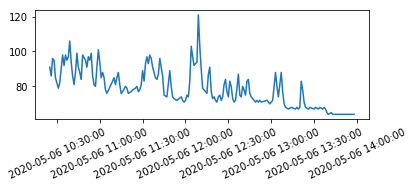

In [25]:
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.xticks( rotation=25 )
plt.plot(df['timestamp'],df['heart_rate'])
plt.gcf().subplots_adjust(bottom=0.5)
plt.savefig(filename.replace('.csv',''))
plt.show()


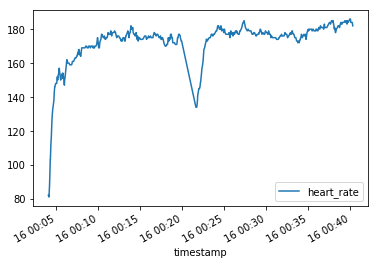

In [32]:
import matplotlib.dates as mdates
ax = df.plot(x='timestamp', y= 'heart_rate')
# set monthly locator
# ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
# # set formatter
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# # set font and rotation for date tick labels
# plt.gcf().autofmt_xdate()

plt.show()

'kacy'

In [52]:
len(df)

508

In [58]:
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)



6207.983333333333


In [41]:
r[1]



timestamp       2020-05-16 00:04:03
heart_rate                       82
timestamp_16                      0
Name: 0, dtype: object